# Abdullah Farid Abdullah _ Group 5

## Project: Finding Donors for *CharityMEL*

CharityMEL is a charity organization located in the heart of Silicon Valley that was established to provide financial support. After nearly 32,000 letters were sent to people in the community, CharityMEL determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityMEL has decided to send letters to residents of California, but to only those most likely to donate to the charity.

With nearly 15 million working Californians, CharityMEL has brought you on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail. Your goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent.

In [76]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first 5 records
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. I have computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [77]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == ">50K"].count()[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == "<=50K"].count()[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = ( n_greater_50k / n_records ) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.4f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.7844%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Data Preprocessing

In [78]:
data.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [79]:
sum(data.duplicated())

5982

In [80]:
data.drop_duplicates(inplace=True)

### Transforming Skewed Continuous Features
With the census dataset two features fit this description (tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number) : '`capital-gain'` and `'capital-loss'`.

In [81]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

In [82]:
def distribution(data, transformed = False):
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot 
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

C:\Users\abahn\AppData\Local\Temp/ipykernel_14060/1568222279.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


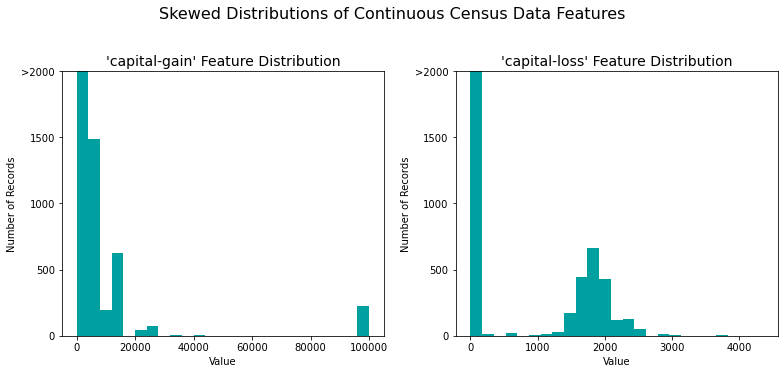

In [83]:
# Visualize skewed continuous features of original data
distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm.

In [84]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

C:\Users\abahn\AppData\Local\Temp/ipykernel_14060/1568222279.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


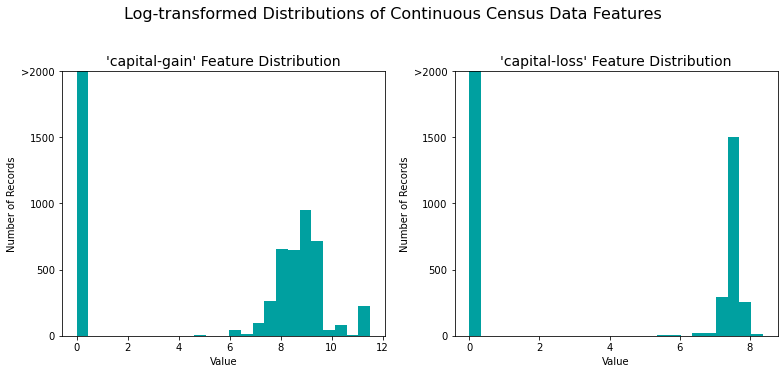

In [85]:
# Visualize the new log distributions
distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [86]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

In [87]:
features_log_minmax_transform.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing
Convert Categorical Features to Numerical Features

In [88]:
# Encode the 'features_log_minmax_transform' data 
features_final = pd.get_dummies(features_log_minmax_transform)

In [89]:
# Encode the 'income_raw' data to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
income = le.fit_transform(income_raw)

In [90]:
# Print the number of features 
encoded = list(features_final.columns)
print("{} total features after encoding.".format(len(encoded)))
print(income)

103 total features after encoding.
[0 0 0 ... 0 0 1]


### Shuffle and Split Data

In [91]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0, stratify = income, shuffle = True)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 31392 samples.
Testing set has 7848 samples.


### Metrics

I am going to use **accuracy** to calculate how often the classifier makes the correct prediction.

In addition, I am going to use another metric which is **F-Score / Harmonic Mean**. This metric combines precision and recall and overcomes the liability of accuracy when it comes to skewed income possibilities

### Why not Accuracy?

Accuracy may not always be the best metric to use


Detecting credit card fraud

We have a bunch of data in the form of credit card transactions. There are 284,335 good transactions and 472 bad transactions. So, let's try to come up with a model that has great accuracy..in other words, a model that is correct most of the time.


Let's use a model that says, all the transactions are good. This model has over 99 percent accuracy, which means it is correct over 99 percent of the time. Now, what is the accuracy of this model? Well, we're correct 284,335 times out of 284,887 times. And that is 99.83 percent.

### Precision VS Recall

### Precision
- Focus on one model's side
- calculate number of correctly classified points in the category over the total number of points in this category.
#### True Positive / Actual Results
### Make Sure that what you are saying is a positive is actually positive

### Recall
- Focus on actual category
- calculate overall correctly classified points over total number of points
#### True positive / Predicted Results
### Makes sure you are not missing on positive observations


    Precision : "out of the patients were diagnosed as sick, how many were actually sick?"
    Recall : "out of the patients that are sick, how many did we correctly diagnose as sick?"


> Identifying someone that does not make more than 50,000 as someone who does would be detrimental to CharityML, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than 50,000 is more important than the model's ability to recall those individuals.

### ML Algorithms

I am going to try 3 possible algorithms which initially I believe will produce a good score and compare their computation time, training scores, and testing scores. 

In addition, I will see the difference in scores while operating on different size samples.

In [92]:
from sklearn.metrics import accuracy_score, fbeta_score, f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples 
    results['acc_train'] = accuracy_score(predictions_train[:300], y_train[:300])
        
    # Compute accuracy on test set 
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # Compute F-score on the the first 300 training samples 
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta=0.5)
        
    # Compute F-score on the test set 
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    return results

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [94]:
# Pre-made visualizations
import visuals as vs

# Set the scores' threshold
TP = np.sum(income)
FP = data.shape[0] - TP
TN = 0
FN = 0
# I assumed all predictions will result in "1"
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
beta = 0.5

fscore = (1 + (beta ** 2)) * (precision * recall) /  ((precision * (beta ** 2)) + recall) 

C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

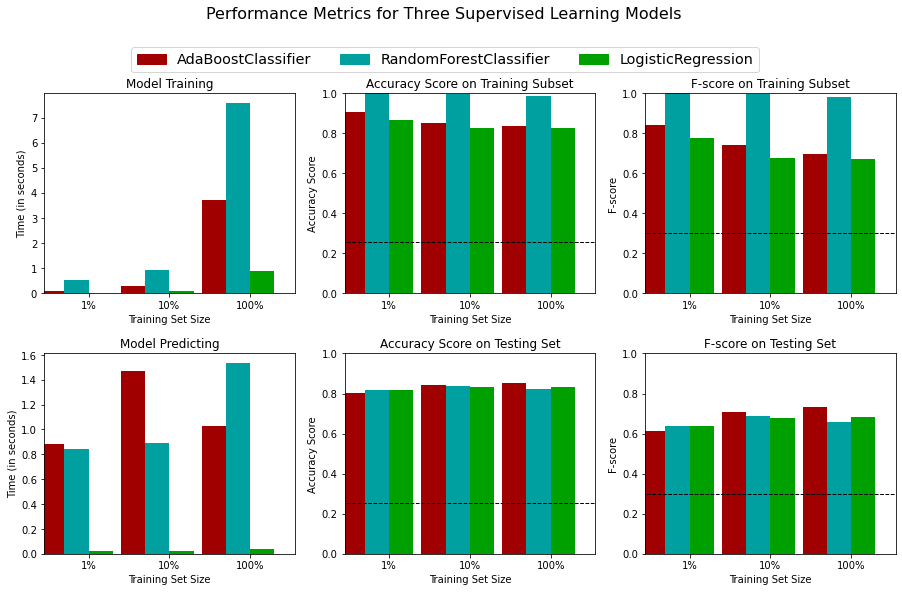

In [118]:
# Initialize the three models
clf_A = AdaBoostClassifier(random_state = 42)
clf_B = RandomForestClassifier(random_state = 30)
clf_C = LogisticRegression(random_state = 50)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three supervised learning models chosen        
vs.evaluate(results, accuracy, fscore)

### Model Tuning: AdaBoostClassifier

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [126]:
# Initialize the classifier
clf = AdaBoostClassifier(random_state = 42)
# Create the parameters list
parameters = {'n_estimators' : [10, 20, 30, 40, 50, 100, 300],
              'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
             }

In [127]:
# Make an fbeta_score scoring object 
scorer = make_scorer(fbeta_score, beta=0.5)
# Perform grid search on the classifier
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

In [128]:
grid_fit = grid_obj.fit(X_train, y_train)

In [129]:
best_clf = grid_fit.best_estimator_

In [130]:
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [131]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8537
F-score on testing data: 0.7329

Optimized Model
------
Final accuracy score on the testing data: 0.8635
Final F-score on the testing data: 0.7506


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8437        |  0.8635         |
| F-score        |  0.7326        |  0.7506        |

### Model Tuning: LogisticRegression

In [35]:
# Initialize the classifier
clf2 = LogisticRegression(random_state = 5)
# Create the parameters list you wish to tune, using a dictionary if needed.
parameters2 = {'C' : [0.001, 0.01, 0.1, 1, 10],
             'max_iter' : [25, 50, 100, 150, 200]
             }

In [36]:
# Make an fbeta_score scoring object 
scorer2 = make_scorer(fbeta_score, beta=0.5)
# Perform grid search on the classifier
grid_obj2 = GridSearchCV(clf2, parameters2, scoring = scorer)

In [37]:
grid_fit2 = grid_obj2.fit(X_train, y_train)

C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [38]:
best_clf2 = grid_fit2.best_estimator_

In [39]:
predictions2 = (clf2.fit(X_train, y_train)).predict(X_test)
best_predictions2 = best_clf2.predict(X_test)
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions2)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions2, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions2)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions2, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8349
F-score on testing data: 0.6847

Optimized Model
------
Final accuracy score on the testing data: 0.8360
Final F-score on the testing data: 0.6881


C:\Users\abahn\AppData\Roaming\SPB_Data\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8349        |  0.8360         |
| F-score        |  0.6847        |  0.6881        |

### Model Tuning : RandomForestClassifier

In [121]:
# Initialize the classifier
clf3 = RandomForestClassifier(random_state = 42)
# Create the parameters list
parameters3 = {'n_estimators' : [10, 20, 50, 100, 200],
              'max_depth' : [2, 4, 6, 8, 10]
             }

In [122]:
# Make an fbeta_score scoring object 
scorer3 = make_scorer(fbeta_score, beta=0.5)
# Perform grid search on the classifier
grid_obj3 = GridSearchCV(clf3, parameters3, scoring = scorer)

In [123]:
grid_fit3 = grid_obj3.fit(X_train, y_train)

In [124]:
best_clf3 = grid_fit3.best_estimator_

In [125]:
predictions3 = (clf3.fit(X_train, y_train)).predict(X_test)
best_predictions3 = best_clf3.predict(X_test)
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions3)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions3, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions3)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions3, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8249
F-score on testing data: 0.6597

Optimized Model
------
Final accuracy score on the testing data: 0.8513
Final F-score on the testing data: 0.7394


|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8249        |  0.8513         |
| F-score        |  0.6597        |  0.7394        |

## I pick AdaBoostClassifier as the better algorithm

### Extracting Feature Importance 

In [112]:
model = AdaBoostClassifier()

model.fit(X_train, y_train)

feature_list = list(X_train.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)

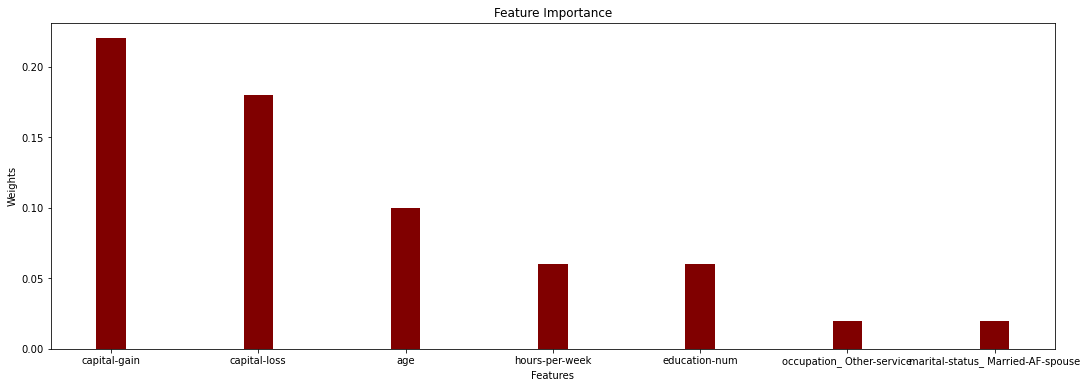

In [113]:
# creating the dataset
feature = list(feature_imp[:7].index)
weight = list(feature_imp[:7].values)

fig = plt.figure(figsize = (18, 6))

# creating the bar plot
plt.bar(feature, weight, color ='maroon',width = 0.2)

plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Feature Importance")
plt.show()

In [114]:
from sklearn.base import clone

# Reduce the feature space
X_train_red = X_train[['capital-loss', 'education-num', 'hours-per-week', 'capital-gain', 'age']]
X_test_red = X_test[['capital-loss', 'education-num', 'hours-per-week', 'capital-gain', 'age']]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_red, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_red)

In [115]:
# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8619
F-score on testing data: 0.7470

Final Model trained on reduced data
------
Accuracy on testing data: 0.8359
F-score on testing data: 0.7034


#### Results:

|     Metric     | Reduced Model | Unreduced Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8359        |  0.8619         |
| F-score        |  0.7034        | 0.7470        |

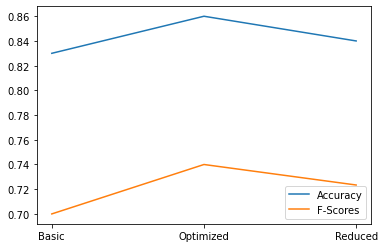

In [120]:
labels = ['Basic','Optimized','Reduced']
accuracy_scores = [0.83, 0.86, 0.84]
fbeta_scores = [0.7, 0.74, 0.7234]

plt.plot(labels, accuracy_scores, label = 'Accuracy')
plt.plot(labels, fbeta_scores, label = 'F-Scores')
plt.legend()
plt.show()